In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

# Example Implementation

Here we provide a minimal working example demonstrating how to use the code to estimate the amplitude using the ESPIRIT algorithm.

In [2]:
# For reproducibility
np.random.seed(7)
# Set the per oracle noise parameter (See Eq. 18)
eta=0
# Set the array parameters (See Thm. II.2 and Eq. 12) 
narray = [2,2, 2, 2, 2, 2]
# Set the actual amplitude
a=0.1
theta = np.arcsin(a)

# This sets up the simulation that simulates the measured amplitudes at the various physical locations.
# It uses a C=1.5 value, which corresponds to the sampling schedule given in Eq. 16. The variable C here 
# is the parameter K in the paper.
ula_signal = TwoqULASignal(M=narray, C=1.5)
# Number of Monte Carlo trials used to estimate statistics. We tend to use 500 in the paper. Choose 100 here for speed.
num_mc = 100
thetas = np.zeros(num_mc, dtype = float)
errors = np.zeros(num_mc, dtype = float)

# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()

for k in range(num_mc):
    signal = ula_signal.estimate_signal(ula_signal.n_samples, theta, eta=eta)
    # This estimates the covariance matrix of Eq. 8 using the approch given in DOI:10.1109/LSP.2015.2409153
    R = ula_signal.get_cov_matrix_toeplitz(signal, theta)
    # This estimates the angle using the ESPIRIT algorithm
    theta_est = espirit.estimate_theta_toeplitz(R)
    # Estimate the error between estimated a and actual a
    error = np.abs(np.sin(theta)-np.sin(theta_est)) 
    thetas[k] = theta_est            
    errors[k] = error

# Compute the total number of queries. The additional count of ula_signal.n_samples[0] is to 
# account for the fact that the Grover oracle has two invocations of the unitary U, but is 
# preceded by a single invocation of U (see Eq. 2 in paper). This accounts for the shots required
# for that single U operator, which costs half as much as the Grover oracle.
num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
# Compute the maximum single query
max_single_query = np.max(ula_signal.depths)

print(f'Array parameters: {narray}')
print(f'Number of queries: {num_queries}')
print(f'theta: {theta}')
print(f'Ave theta estimated: {np.mean(thetas)}')
print(f'a = {a}; a_est = {np.sin(np.mean(thetas))}')
print(f'Max Single Query: {max_single_query}')
print(f'99% percentile: {np.percentile(errors, 99):e}')
print(f'95% percentile: {np.percentile(errors, 95):e}')
print(f'68% percentile: {np.percentile(errors, 68):e}')
print()


Array parameters: [2, 2, 2, 2, 2, 2]
Number of queries: 413
theta: 0.1001674211615598
Ave theta estimated: 0.09859784380940485
a = 0.1; a_est = 0.09843816771564176
Max Single Query: 32
99% percentile: 1.491364e-02
95% percentile: 1.034658e-02
68% percentile: 4.509476e-03



In [3]:
# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()


narray = [2,2,2, 2, 2, 2]
# Set the actual amplitude
a=0.3
theta = np.arcsin(a)

ula_signal = TwoqULASignal(M=narray, C=1.5)
# n_samples = [20 for _ in range(len(ula_signal.n_samples))]
n_samples = 2*ula_signal.n_samples
signal = ula_signal.estimate_signal(n_samples, theta)
cos_signal = ula_signal.cos_signal

print(cos_signal)

num_mc = 50
thetas = np.zeros(num_mc, dtype = float)
errors = np.zeros(num_mc, dtype = float)
cos_values = np.zeros(num_mc, dtype = float)
for k in range(num_mc):
    # This estimates the covariance matrix of Eq. 8 using the approch given in DOI:10.1109/LSP.2015.2409153
    R = ula_signal.get_cov_matrix_toeplitz(cos_signal, theta)
    # This estimates the angle using the ESPIRIT algorithm
    theta_est = espirit.estimate_theta_toeplitz(R)
    # Estimate the error between estimated a and actual a
    error = np.abs(np.cos(theta)-np.cos(theta_est))
    cos_values[k] = np.cos(theta_est)
    thetas[k] = theta_est            
    errors[k] = error

print(f'theta: {theta}')
print(f'thetas: {thetas}')
print(f'a: {a}')
print(f'cos values: {cos_values}')
print()

[ 0.68181818+0.j -0.44444444+0.j -0.9375    +0.j  0.75      +0.j
 -0.7       +0.j  0.        +0.j -0.25      +0.j]
theta: 0.30469265401539747
thetas: [0.46724327 1.10355306 0.46724327 0.46724327 0.46724327 0.46724327
 0.46724327 0.46724327 1.10355306 0.46724327 0.46724327 0.46724327
 0.46724327 1.10355306 1.10355306 0.46724327 1.10355306 0.46724327
 1.10355306 0.46724327 0.46724327 0.46724327 0.46724327 0.46724327
 0.46724327 0.46724327 0.46724327 0.46724327 0.46724327 0.46724327
 0.46724327 0.46724327 0.46724327 1.10355306 1.10355306 0.46724327
 0.46724327 1.10355306 1.10355306 1.10355306 0.46724327 1.10355306
 0.46724327 0.46724327 0.46724327 0.46724327 1.10355306 1.10355306
 1.10355306 1.10355306]
a: 0.3
cos values: [0.89281339 0.45042675 0.89281339 0.89281339 0.89281339 0.89281339
 0.89281339 0.89281339 0.45042675 0.89281339 0.89281339 0.89281339
 0.89281339 0.45042675 0.45042675 0.89281339 0.45042675 0.89281339
 0.45042675 0.89281339 0.89281339 0.89281339 0.89281339 0.89281339
 0.

[ 0.918+0.j  0.342+0.j -0.436+0.j -0.887+0.j  0.831+0.j  0.763+0.j
  0.54 +0.j]


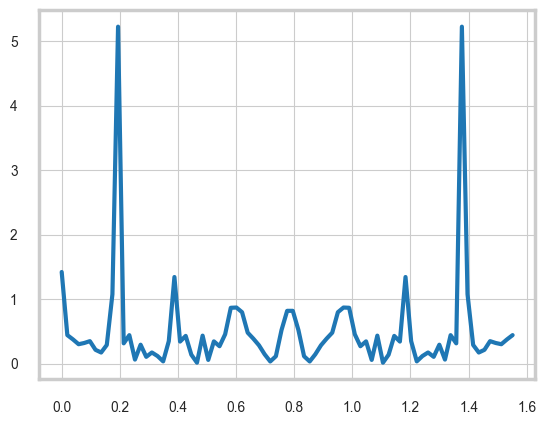

In [172]:
narray = [2,2, 2, 2, 2, 2]
# Set the actual amplitude
a=0.2
theta = np.arcsin(a)

ula_signal = TwoqULASignal(M=narray, C=1.5)
n_samples = [1000 for _ in range(len(ula_signal.n_samples))]
# n_samples = 2*ula_signal.n_samples
signal = ula_signal.estimate_signal(n_samples, theta)
cos_signal = ula_signal.cos_signal

print(cos_signal)

cos_signal_ext = ula_signal.get_cov_matrix_toeplitz(cos_signal, C=1.2)

fft = np.abs(np.fft.fft(cos_signal_ext))

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

In [173]:
amax = np.argmax(fft[:len(fft)//2])
np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft))

(1.3768708543510821, 0.1939254724438144)

In [174]:
np.cos(np.pi*(len(fft)-amax)/(2*len(fft))), np.cos(np.pi*(amax)/(2*len(fft)))

(0.19271226054808976, 0.9812553106273847)

In [55]:
np.pi/8

0.39269908169872414